In [2]:
import datetime as dt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import cv2
import numpy as np
import os
import sys
import random
import warnings
from sklearn.datasets import load_files 
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.transform import resize
import shutil
from PIL import ImageFile 

import keras

from keras import backend as K
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization, Input, ZeroPadding2D, GlobalAveragePooling2D
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import shutil
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow as tf
                 


from keras.models import load_model

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
from keras.applications import inception_v3
from keras.applications.inception_v3 import InceptionV3
from keras.applications import mobilenet_v2
from keras.applications.nasnet import NASNetMobile
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor

Using TensorFlow backend.


In [3]:
working_path = "/Users/Daniel/Desktop/dogImages/"
!ls "/Users/Daniel/Desktop/dogImages"

test  train valid


In [4]:
'''
This function will open the files in a folder and return the name of the folder and count the number of files
in the folder. It then makes it into a DataFrame for ease of use.
'''

for root, dirs, files in os.walk('/Users/Daniel/Desktop/dogImages/train/', topdown=False):
    name_list = []
    count_list =[]
    
    for name in dirs:
        name_list.append(name)
        list = os.listdir('/Users/Daniel/Desktop/dogImages/train/'+ name)
        number_files = len(list)
        count_list.append(number_files)
        
    
    df = pd.DataFrame(name_list)
    df2 = pd.DataFrame(count_list)
    df3 = pd.concat([df, df2], axis=1)
    


In [5]:
df3.max

<bound method DataFrame.max of                                           0   0
0                               122.Pointer  32
1                        069.French_bulldog  51
2                                124.Poodle  50
3    112.Nova_scotia_duck_tolling_retriever  54
4                            043.Canaan_dog  50
..                                      ...  ..
128                            092.Keeshond  44
129                             100.Lowchen  34
130                     052.Clumber_spaniel  49
131                              095.Kuvasz  49
132                   090.Italian_greyhound  58

[133 rows x 2 columns]>

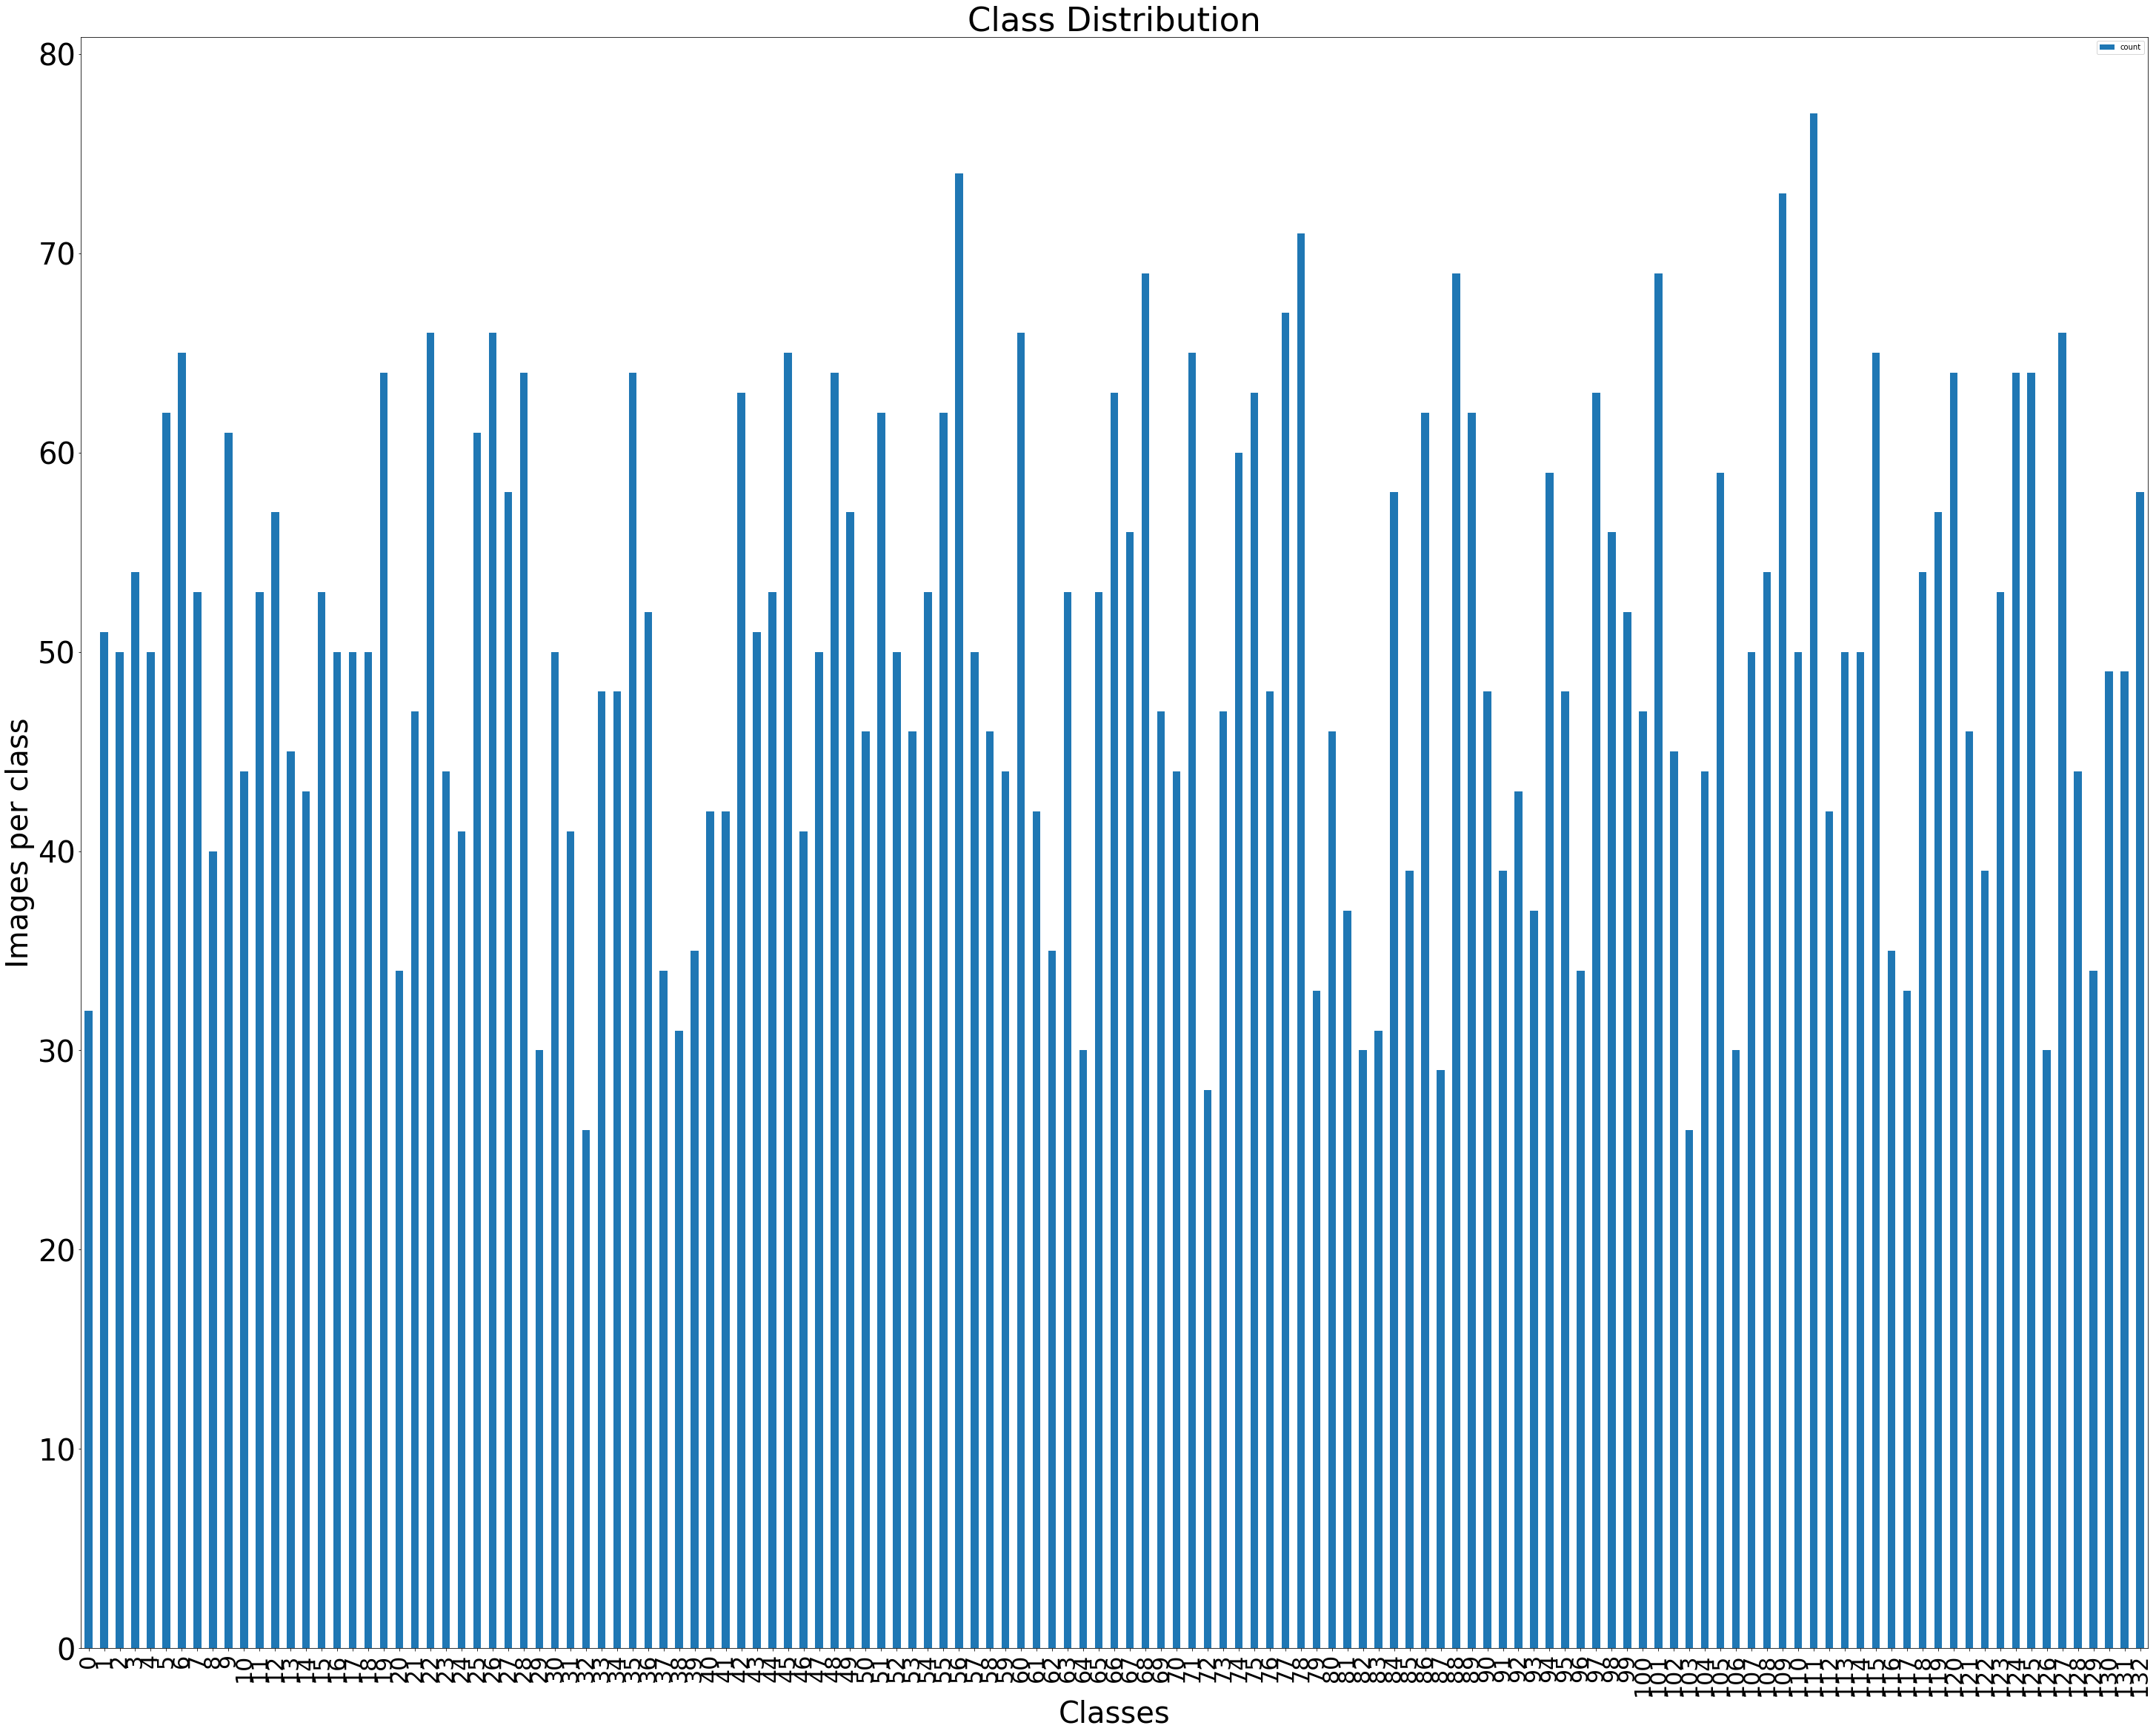

In [492]:
'''
Plot the distribution of dog breeds and the number of images in the training set.
'''

df3.columns=['breed', 'count']
ax = df3.plot(kind = 'bar', fontsize='40', title ='Class Distribution', figsize=(50,40))
ax.set(xlabel="Classes", ylabel="Images per class")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(45)
plt.xticks(fontsize=30)
plt.show()

In [879]:
df3.mean()

count    50.225564
dtype: float64

In [836]:
'''
This function will go into each folder (train,valid,test) and identify the path of a image and then it will use
to_categorical to make a one hot encoding sequence of the file as the target. 
https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/
'''

def get_data(path):
    data = load_files(path)
    dog_x = np.array(data['filenames'])
    dog_y = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_x, dog_y

train_x, train_y = get_data('/Users/Daniel/Desktop/dogImages/train')
valid_x, valid_y = get_data('/Users/Daniel/Desktop/dogImages/valid')
test_x, test_y = get_data('/Users/Daniel/Desktop/dogImages/test')

In [841]:
# take a look at the first image. 

print(train_x[0])
train_y[0]

/Users/Daniel/Desktop/dogImages/train/095.Kuvasz/Kuvasz_06442.jpg


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [842]:
#take a look at the number of images in each set

print('There are %d training images.' % len(train_x))
print('There are %d validation images.' % len(valid_x))
print('There are %d test images.'% len(test_files))

There are 6680 training images.
There are 835 validation images.
There are 836 test images.


In [324]:
# convert Image type to 3D tensor with shape (224, 224, 3)
# convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
#code from CNN notebook

def prepare_image(img_path):
    
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

# This function below will return a list of tensors for us to work with

def prepare_tensor(img_paths):
    list_of_tensors = [prepare_image(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

In [325]:
# ImageFile.LOAD_TRUNCATED_IMAGES = True     
# rescaling the images 


train_t = prepare_tensor(train_x).astype('float32')/255
valid_t = prepare_tensor(valid_x).astype('float32')/255
test_t = prepare_tensor(test_x).astype('float32')/255

## Sequential Model 

This is one of the best sequential model that I have built, however, it has not been able to reach an acceptable accuracy. I have experimented by adding more layers but the accuracy doesn't seem to get past 1.2%. This could be due to not having enough images per dog breed to train on. 



Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

strides indicate the number of steps in which the filter window moves. Large stride values decrease the size of the information that will be passed to the next layer. 




In [371]:
NN = Sequential()

NN.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(224, 224, 3)))
NN.add(BatchNormalization(axis=3, scale=False))
NN.add(Activation("relu"))
NN.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
NN.add(Dropout(0.2))

NN.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
NN.add(BatchNormalization(axis=3, scale=False))
NN.add(Activation("relu"))
NN.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
NN.add(Flatten()) #flatten here
NN.add(Dropout(0.2))

NN.add(Dense(512, activation='relu'))
NN.add(Dense(133, activation='softmax'))
NN.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1474 (Conv2D)         (None, 224, 224, 16)      432       
_________________________________________________________________
batch_normalization_1456 (Ba (None, 224, 224, 16)      48        
_________________________________________________________________
activation_1897 (Activation) (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_131 (MaxPoolin (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_1475 (Conv2D)         (None, 56, 56, 32)        4608      
_________________________________________________________________
batch_normalization_1457 (Ba (None, 56, 56, 32)      

In [843]:
# set epochs, optimizer, loss, and metric
# rmsprop and adam were both used as optimizers. Both resulted in similar results. 
# Use checkpointer to save the best model weights in case needs to be used later. 

EPOCHS = 20
NN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
                               verbose=1, save_best_only=True)
NN.fit(train_tensors, train_y, 
           validation_data=(valid_tensors, valid_y),
           epochs=EPOCHS, 
           batch_size=32, 
           callbacks=[checkpointer], 
           verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 256s 38ms/step - loss: 3.8697 - accuracy: 0.0921 - val_loss: 4.3735 - val_accuracy: 0.0539

Epoch 00001: val_loss improved from inf to 4.37350, saving model to weights-improvement-01-0.05.hdf5
Epoch 2/20
6680/6680 [==============================] - 189s 28ms/step - loss: 3.7927 - accuracy: 0.1007 - val_loss: 4.2467 - val_accuracy: 0.0623

Epoch 00002: val_loss improved from 4.37350 to 4.24671, saving model to weights-improvement-02-0.06.hdf5
Epoch 3/20
6680/6680 [==============================] - 218s 33ms/step - loss: 3.7211 - accuracy: 0.1135 - val_loss: 4.3212 - val_accuracy: 0.0659

Epoch 00003: val_loss did not improve from 4.24671
Epoch 4/20
6680/6680 [==============================] - 206s 31ms/step - loss: 3.6481 - accuracy: 0.1283 - val_loss: 4.3777 - val_accuracy: 0.0659

Epoch 00004: val_loss did not improve from 4.24671
Epoch 5/20
6680/6680 [==============================]

In [846]:
#dog_pred gets the highest predicted dog breed. the final accuracy is the ones that are correctly predicted
#divided by the total number 

NN.load_weights('/Users/Daniel/weights-improvement-02-0.06.hdf5')

dog_pred = [np.argmax(NN.predict(np.expand_dims(tensor, axis=0))) for tensor in test_t]

final_acc = 100*np.sum(np.array(dog_pred)==np.argmax(test_y, axis=1))/len(dog_pred)
print('The accuracy on test data is: %.4f%%' % test_accuracy)

The accuracy on test data is: 0.9569%


## Transfer Learning

Using VGG19, Resnet50

In [83]:
#this function will use pre-trained models as a feature extractor. It extracts the last convolutional output from 
#both models

def extract_VGG19(file_paths):
    tensors = paths_to_tensor(file_paths).astype('float32')
    preprocessed_input = preprocess_input_vgg19(tensors)
    return VGG19(weights='imagenet', include_top=False).predict(preprocessed_input, batch_size=32)

def extract_Resnet50(file_paths):
    tensors = paths_to_tensor(file_paths).astype('float32')
    preprocessed_input = preprocess_input_resnet50(tensors)
    return ResNet50(weights='imagenet', include_top=False).predict(preprocessed_input, batch_size=32)



In [365]:
#Use pre-trained models on the train, validation, and test images
# Code borrowed from Machinememo

train_vgg19 = extract_VGG19(train_files)
valid_vgg19 = extract_VGG19(valid_files)
test_vgg19 = extract_VGG19(test_files)
print("VGG19 shape", train_vgg19.shape[1:])

train_resnet50 = extract_Resnet50(train_files)
valid_resnet50 = extract_Resnet50(valid_files)
test_resnet50 = extract_Resnet50(test_files)
print("Resnet50 shape", train_resnet50.shape[1:])

  0%|          | 7/6680 [00:00<01:40, 66.71it/s]

VGG19 shape (7, 7, 512)


100%|██████████| 6680/6680 [01:31<00:00, 73.08it/s] 
/opt/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
100%|██████████| 836/836 [00:10<00:00, 82.37it/s] 


Resnet50 shape (7, 7, 2048)


In [366]:
#Building the transfer learning neural network. this cell uses a combination of VGG19 and ResNet50 to build.
#Then add another layer that adds dropout and batch normalization 
# This cell of code is from Machinememo.



def input_branch(input_shape=None):
    
    size = int(input_shape[2] / 4)
    
    branch_input = Input(shape=input_shape)
    branch = GlobalAveragePooling2D()(branch_input)
    branch = Dense(size, use_bias=False, kernel_initializer='uniform')(branch)
    branch = BatchNormalization()(branch)
    branch = Activation("relu")(branch)
    return branch, branch_input

vgg19_branch, vgg19_input = input_branch(input_shape=(7, 7, 512))
resnet50_branch, resnet50_input = input_branch(input_shape=(7, 7, 2048))

concatenate_branches = Concatenate()([vgg19_branch, resnet50_branch])



net = Dropout(0.3)(concatenate_branches)
net = Dense(640, use_bias=False, kernel_initializer='uniform')((net))
net = BatchNormalization()(net)
net = Activation("relu")(net)
net = Dropout(0.3)(net)
net = Dense(133, kernel_initializer='uniform', activation="softmax")(net)

model = Model(inputs=[vgg19_input, resnet50_input], outputs=[net])
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           (None, 7, 7, 2048)   0                                            
__________________________________________________________________________________________________
global_average_pooling2d_31 (Gl (None, 512)          0           input_53[0][0]                   
__________________________________________________________________________________________________
global_average_pooling2d_32 (Gl (None, 2048)         0           input_54[0][0]                   
___________________________________________________________________________________________

In [367]:
model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5', 
                               verbose=1, save_best_only=True)

fit_model = model.fit([train_vgg19, train_resnet50], train_y, 
          validation_data=([valid_vgg19, valid_resnet50], valid_y),
          epochs=20, batch_size=512, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 8s 1ms/step - loss: 2.8263 - accuracy: 0.4602 - val_loss: 2.1273 - val_accuracy: 0.6060

Epoch 00001: val_loss improved from inf to 2.12729, saving model to weights-improvement-01-0.61.hdf5
Epoch 2/20
6680/6680 [==============================] - 5s 822us/step - loss: 1.1938 - accuracy: 0.7778 - val_loss: 1.6397 - val_accuracy: 0.7138

Epoch 00002: val_loss improved from 2.12729 to 1.63973, saving model to weights-improvement-02-0.71.hdf5
Epoch 3/20
6680/6680 [==============================] - 6s 852us/step - loss: 0.7575 - accuracy: 0.8506 - val_loss: 1.3816 - val_accuracy: 0.7581

Epoch 00003: val_loss improved from 1.63973 to 1.38158, saving model to weights-improvement-03-0.76.hdf5
Epoch 4/20
6680/6680 [==============================] - 6s 891us/step - loss: 0.5344 - accuracy: 0.8936 - val_loss: 1.2085 - val_accuracy: 0.7916

Epoch 00004: val_loss improved from 1.38158 to 1.20848, 

In [860]:
#This is a simple function that will plot the training and validation accuracy and loss. 
#modified code from stackoverflow

def train_val_acc_loss(model):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy,  color='blue', mec='k', label='Training accuracy')
    plt.plot(epochs, val_accuracy, color='red', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, color='blue', label='Training loss')
    plt.plot(epochs, val_loss, color='red', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

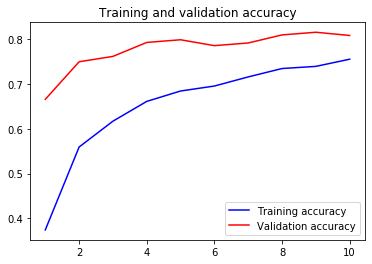

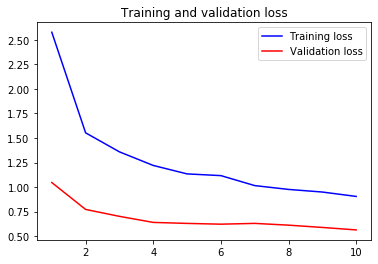

In [861]:
train_val_acc_loss(fit_model)

If validation loss >> training loss you can call it overfitting.
If validation loss  > training loss you can call it some overfitting.
If validation loss  < training loss you can call it some underfitting.
If validation loss << training loss you can call it underfitting.

In [370]:
#predictions gives you the probabilies of the image belonging to a breed
#dog_predictions gives you the highest predicted breed for the image
#dog_true is the true label of the image

model.load_weights('/Users/Daniel/weights-improvement-08-0.80.hdf5')

predictions = model.predict([test_vgg19, test_resnet50])
dog_predictions = [np.argmax(prediction) for prediction in predictions]
dog_true = [np.argmax(true_label) for true_label in test_y]
print('Test accuracy: %.2f%%' % (accuracy_score(dog_true, dog_predictions) * 100))

Test accuracy: 80.9809%


In [824]:
# check to see if there is a pattern in predicting the wrong breed. 
# make a df that has the predicted label and the true label

df_wrong_ones = pd.DataFrame(dog_predictions, columns= ['predictions'])
df_right_ones = pd.DataFrame(dog_true, columns= ['true_label'])

final_df = pd.concat([df_wrong_ones, df_right_ones], axis=1, )

In [829]:
#Check to see if it is predicted correctly, if it is, then return True. Else return False
final_df['contains'] = final_df.astype(str).apply(lambda x: x.true_label in x.predictions, axis=1)

In [844]:
final_df.head(5)

,predictions,true_label,contains
0,56,56,True
1,58,58,True
2,114,114,True
3,18,18,True
4,67,67,True


In [832]:
# Check how many are correct and wrong

final_df['contains'].value_counts()

True     681
False    155
Name: contains, dtype: int64

In [833]:
# df of only the ones that were predicted incorrectly

final_pred = final_df.loc[final_df['contains'] == False]
final_pred

,predictions,true_label,contains
8,92,96,False
12,81,74,False
15,44,13,False
23,95,94,False
25,123,124,False
...,...,...,...
811,81,100,False
815,75,78,False
822,102,9,False
825,28,114,False


In [835]:
# looks like the model is stuggling at predicting breed #60 and #40
final_pred['true_label'].value_counts()

60    7
40    6
94    4
0     3
12    3
     ..
67    1
66    1
62    1
57    1
65    1
Name: true_label, Length: 88, dtype: int64

## Top 4 predictions

Lets see if the true result is in top 4 predicted result.

In [787]:
# get a list of the top 4 predictions

top4pred = [np.argpartition(prediction, -4)[-4:] for prediction in predictions]

In [788]:
top4pred

[array([48, 61, 77, 56]),
 array([17, 77, 58, 69]),
 array([ 90,  83, 114,  47]),
 array([ 94,  23, 123,  18]),
 array([54, 95, 67, 75]),
 array([32, 73, 67, 20]),
 array([ 28, 127,  44,  42]),
 array([98, 52, 81, 51]),
 array([124,   2,  96,  92]),
 array([49, 50,  3, 66]),
 array([60, 61, 48,  1]),
 array([ 96,  23, 123,  18]),
 array([ 74,  57,  81, 118]),
 array([ 57, 110, 126, 132]),
 array([ 2, 26, 19, 70]),
 array([ 42, 117,  13,  44]),
 array([ 50,  66,  83, 122]),
 array([19, 31, 68, 47]),
 array([ 37, 122,  90, 116]),
 array([106, 110,  41,  74]),
 array([ 50,  21,  97, 125]),
 array([47, 39, 68, 31]),
 array([118,  29, 113,  55]),
 array([ 9, 94, 78, 95]),
 array([70, 73, 25, 35]),
 array([  8, 124, 123,  92]),
 array([ 93,  88,  18, 123]),
 array([131, 123,  89,  18]),
 array([21, 20, 91, 50]),
 array([ 23,  93,  16, 112]),
 array([107,   3, 109,   4]),
 array([ 91, 107,   3, 108]),
 array([31, 44, 28, 11]),
 array([11, 64, 22, 79]),
 array([ 78, 128,  50, 105]),
 array([12

In [789]:
# make the top4 predictions into a dataframe and combine them. 

prediction_df = pd.DataFrame(top4pred)
prediction_df.columns = ['prediction', '1', '2', '3']
prediction_df['combined'] = prediction_df.values.tolist()
prediction_df

,prediction,1,2,3,combined
0,48,61,77,56,"[48, 61, 77, 56]"
1,17,77,58,69,"[17, 77, 58, 69]"
2,90,83,114,47,"[90, 83, 114, 47]"
3,94,23,123,18,"[94, 23, 123, 18]"
4,54,95,67,75,"[54, 95, 67, 75]"
...,...,...,...,...,...
831,0,37,116,98,"[0, 37, 116, 98]"
832,49,24,26,102,"[49, 24, 26, 102]"
833,45,116,114,90,"[45, 116, 114, 90]"
834,69,80,89,101,"[69, 80, 89, 101]"


In [790]:
true_df = pd.DataFrame(dog_true, columns = ['true_label'])

In [791]:
#concat the true label to the top 4 predictions 

prediction_true_df = pd.concat([prediction_df, true_df], axis = 1)

In [792]:
prediction_true_df

,prediction,1,2,3,combined,true_label
0,48,61,77,56,"[48, 61, 77, 56]",56
1,17,77,58,69,"[17, 77, 58, 69]",58
2,90,83,114,47,"[90, 83, 114, 47]",114
3,94,23,123,18,"[94, 23, 123, 18]",18
4,54,95,67,75,"[54, 95, 67, 75]",67
...,...,...,...,...,...,...
831,0,37,116,98,"[0, 37, 116, 98]",116
832,49,24,26,102,"[49, 24, 26, 102]",26
833,45,116,114,90,"[45, 116, 114, 90]",90
834,69,80,89,101,"[69, 80, 89, 101]",80


In [793]:
# check to see if true label is in the top4 predictions

prediction_true_df['contains'] = prediction_true_df.astype(str).apply(lambda x: x.true_label in x.combined, axis=1)

In [794]:
prediction_true_df.head(10)

,prediction,1,2,3,combined,true_label,contains
0,48,61,77,56,"[48, 61, 77, 56]",56,True
1,17,77,58,69,"[17, 77, 58, 69]",58,True
2,90,83,114,47,"[90, 83, 114, 47]",114,True
3,94,23,123,18,"[94, 23, 123, 18]",18,True
4,54,95,67,75,"[54, 95, 67, 75]",67,True
5,32,73,67,20,"[32, 73, 67, 20]",20,True
6,28,127,44,42,"[28, 127, 44, 42]",42,True
7,98,52,81,51,"[98, 52, 81, 51]",51,True
8,124,2,96,92,"[124, 2, 96, 92]",96,True
9,49,50,3,66,"[49, 50, 3, 66]",50,True


In [795]:
# looks like the true label is in the top4 predictions ~97% of the time 
prediction_true_df['contains'].value_counts()

True     812
False     24
Name: contains, dtype: int64

In [796]:
#percent of incorrectly classified
24/812*100

2.955665024630542

In [808]:
#lets see if there is a pattern in the wrong predictions

f_pred = prediction_true_df.loc[prediction_true_df['contains'] == False]
f_pred

,prediction,1,2,3,combined,true_label,contains
67,120,71,95,46,"[120, 71, 95, 46]",121,False
96,50,97,111,75,"[50, 97, 111, 75]",128,False
98,71,54,8,120,"[71, 54, 8, 120]",34,False
111,34,52,62,65,"[34, 52, 62, 65]",60,False
150,32,130,92,72,"[32, 130, 92, 72]",124,False
179,9,102,19,108,"[9, 102, 19, 108]",62,False
180,24,76,55,63,"[24, 76, 55, 63]",45,False
300,42,109,107,83,"[42, 109, 107, 83]",47,False
310,3,42,83,66,"[3, 42, 83, 66]",107,False
342,76,55,58,69,"[76, 55, 58, 69]",17,False


In [807]:
# looks like no aparent pattern
f_pred['true_label'].value_counts()

121    2
17     2
98     1
45     1
34     1
99     1
132    1
43     1
57     1
114    1
124    1
44     1
77     1
62     1
47     1
112    1
109    1
81     1
107    1
127    1
60     1
128    1
Name: true_label, dtype: int64

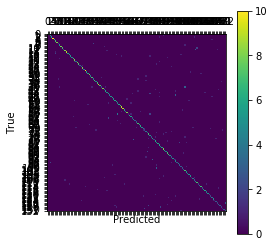

In [526]:
cm = confusion_matrix(breed_true_labels, breed_predictions)

plt.matshow(cm)
plt.colorbar()

plt.xticks(range(133))
plt.yticks(range(133))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()